In [ ]:
import pandas as pd
import os
import numpy as np
import random 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/My Drive/project_data/train_data.csv')
data = train_data.copy()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
feature_description = pd.read_excel('/content/drive/My Drive/project_data/data_dictionary.xlsx')
feature_description

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [ ]:
def data_preprocessing(data, miss_threshold, category):
    '''
    Data: dataframe type original data
    miss_threhold: float type, determine whether keep the feature
    category: boolean type, determine whether keep categoical data
    '''
    if category == False: 
        categorical = []
        for name in data.columns:
            for x in data[name][data[name].isna() == False]:
                if type(x) != str:
                    categorical.append(name)
                    break
        data = data[categorical]
                
    
    data = data[[x for x in data.columns if (sum(data[x].isna())/len(data)) <= miss_threshold]]
    unchanged_feature = [x for x in data.columns if len(data[x].unique()) == 1]
    data = data.drop(unchanged_feature, axis = 1)
    
    return data

In [ ]:
label = data['loan_status']
data = data.drop(['loan_status'], axis = 1)

for i in range(len(label)):
    if label[i] == 'Charged Off':
        label[i] = 1
    else:
        label[i] = 0

import sklearn.model_selection as model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(data, label, train_size=0.7,test_size=0.3, random_state=101, stratify = label)

In [ ]:
miss_threshold = 0.25
category = False
X_train = data_preprocessing(X_train, miss_threshold, category)

In [ ]:
def categorical_check(df, threshold):
    non_cate = []
    for x in df.columns:
        if len(df[x].unique()) >= threshold:
            non_cate.append(x)
            
    return df[non_cate]

In [ ]:
threshold = 100
numerical = categorical_check(X_train, threshold)
numerical3 = numerical.drop(['recoveries', 'out_prncp', 'out_prncp_inv', 'collection_recovery_fee'], axis = 1)
numerical_test3 = X_test[numerical3.columns]

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=100, random_state=0)

y_train = np.array(y_train.astype(int))
y_test = np.array(y_test.astype(int))

mice_imp_x = imp.fit_transform(numerical3, y = y_train)
mice_imp_x_test = imp.fit(numerical3, y = y_train).transform(numerical_test3)

In [ ]:
from sklearn import preprocessing

def stadardize(X):
  scaler = preprocessing.StandardScaler().fit(X)
  X = scaler.transform(X)
  return X

In [ ]:
mice_imp_x = stadardize(mice_imp_x)

mice_imp_x_test = stadardize(mice_imp_x_test)

## Convolutional Neural Network


##### Structure: 

ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

Example Architecture: Overview. We will go into more details below, but a simple ConvNet for CIFAR-10 classification could have the architecture [INPUT - CONV1 - RELU - CONV2 - RELU - FC - FC].

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        kernel_size = 3
        self.input_dim = input_dim
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=3, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv1d(in_channels=3, out_channels=3, kernel_size=kernel_size)
        self.linear1 = nn.Linear((input_dim-2*(kernel_size-1))*3, 10)
        self.linear2 = nn.Linear(10, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_data):
        conv_out1 = self.conv1(input_data.view(input_data.size()[0], 1, input_data.size()[1]))
        conv_out1 = nn.ReLU()(conv_out1)
        conv_out2 = self.conv2(conv_out1)
        conv_out2 = nn.ReLU()(conv_out2)
        linear1 = self.linear1(conv_out2.view(conv_out2.size()[0], -1))
        linear1 = nn.ReLU()(linear1)
        linear2 = self.linear2(linear1)
        y_pred = self.sigmoid(linear2)
        return y_pred

In [ ]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_input = mice_imp_x.shape[1]
cnn_model = CNN(input_dim= n_input, output_dim=1)
cnn_model.to(device)
learning_rate = 0.008
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 40
batch_size = 128

train_x = torch.tensor(mice_imp_x,dtype = torch.float)
test_x = torch.tensor(mice_imp_x_test,dtype = torch.float)
train_y = torch.tensor(y_train,dtype = torch.float)
test_y = torch.tensor(y_test,dtype = torch.float)

for t in range(num_epochs):
    total_loss = 0
    for i in range(len(train_x)//batch_size):
        optimiser.zero_grad()
        batch_data = train_x[i*batch_size:(i+1)*batch_size]
        batch_label = train_y[i*batch_size:(i+1)*batch_size]
        y_pred = cnn_model(batch_data.float())
        # weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss()(y_pred, batch_label)        #cnn_writer.add_scalar('CNN loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch 0: 0.09741280227899551
epoch 1: 0.0791642889380455
epoch 2: 0.07459075003862381
epoch 3: 0.07368170469999313
epoch 4: 0.07344461232423782
epoch 5: 0.0730099305510521
epoch 6: 0.07294480502605438
epoch 7: 0.07287263870239258
epoch 8: 0.07278874516487122
epoch 9: 0.07258531451225281
epoch 10: 0.07193247228860855
epoch 11: 0.07203179597854614
epoch 12: 0.07188287377357483
epoch 13: 0.07166395336389542
epoch 14: 0.071556955575943
epoch 15: 0.07176217436790466
epoch 16: 0.07146111130714417
epoch 17: 0.0714334100484848
epoch 18: 0.0713324323296547
epoch 19: 0.07121387124061584
epoch 20: 0.07101451605558395
epoch 21: 0.07114891707897186
epoch 22: 0.07119790464639664
epoch 23: 0.07124759256839752
epoch 24: 0.07098409533500671
epoch 25: 0.07108124345541
epoch 26: 0.07057098299264908
epoch 27: 0.07091677933931351
epoch 28: 0.07081902027130127
epoch 29: 0.07074030488729477
epoch 30: 0.07067129760980606
epoch 31: 0.07075726240873337
epoch 32: 0.0706469863653183
epoch 33: 0.07070007920265198


In [ ]:
torch.save(cnn_model,(str(cnn_model).split()[0][:-1])+'_2')

In [ ]:
pred = cnn_model(test_x).cpu()
pred = pred.data.numpy()

In [ ]:
pred = pred.ravel()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, pred)
auc(fpr, tpr)

0.9491397918961059

In [ ]:
fpr, tpr, _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc = auc(fpr, tpr)

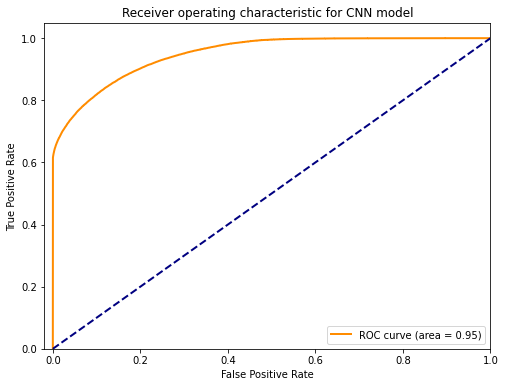

In [ ]:
plt.figure(figsize= (8,6))

lw = 2
plt.plot(fpr, tpr, color='darkorange', 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_test, pred)

0.9491397918961059

### Select the best threshold to determine the label

In [ ]:
def pred_convert(pred, threshold):

  result = np.array([0 for _ in range(len(pred))])
  result[pred.flatten() > threshold] = 1
  return result

In [ ]:
from numpy import arange

threshold = arange(0, 1, 0.01)
auc_dict = {}
for x in threshold:
  y_hat = pred_convert(pred, x)
  auc_dict[x] = roc_auc_score(y_test, y_hat)

auc_dict = {k: v for k, v in sorted(auc_dict.items(), key=lambda item: item[1], reverse = True)}


In [ ]:
gmeans = (tpr * (1-fpr))** 0.5
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.055948, G-Mean=0.860


In [ ]:
label = pred_convert(pred, 0.055)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, label)
print('The best AUC threhold 0.05 is {}.'.format(auc(fpr, tpr)))

The best AUC threhold 0.05 is 0.8600036340001063.


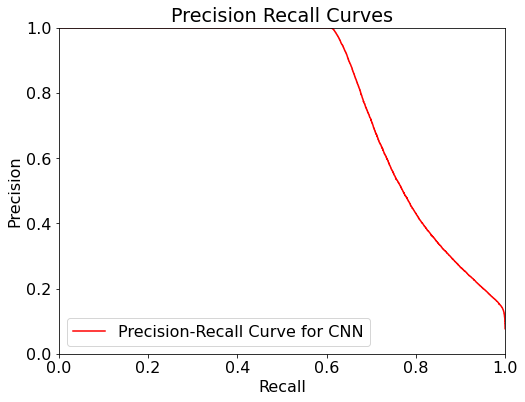

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, pred)



plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(recall, precision, 'r', label='Precision-Recall Curve for CNN')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Precision Recall Curves')
plt.legend(loc="lower left")
plt.show()

Normalized confusion matrix
[[0.87625571 0.12374429]
 [0.15624844 0.84375156]]


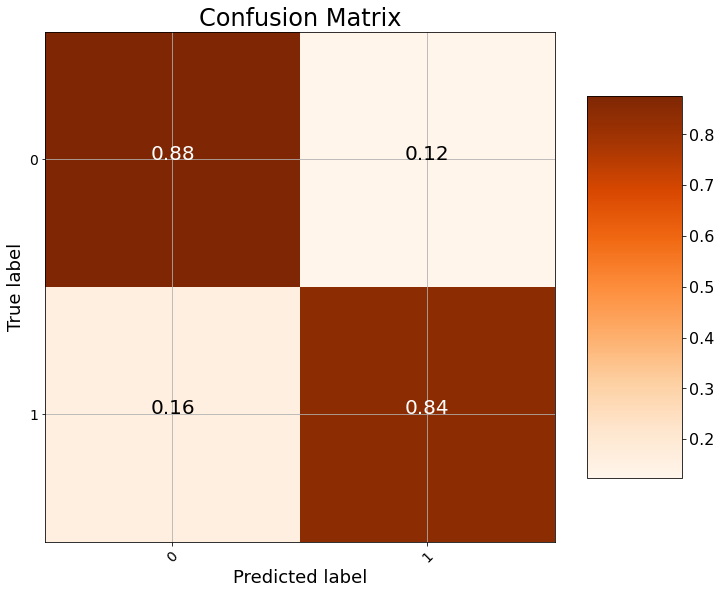

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, label)
plot_confusion_matrix(cm, classes = ['0', '1'], normalize = True, 
                      title = 'Confusion Matrix')

Code Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html